In [1]:
import pandas as pd
import numpy as py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import json
import spacy
import collections

In [2]:
dataset  = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [3]:
    """
    Preprocessing of the headlines.
     * Word tokenization,
     * Lower case,
     * Stop word removal,
     * Punctuation removal,
     * Digit removal,
     * Lemmatization.
    """

'\nPreprocessing of the headlines.\n * Word tokenization,\n * Lower case,\n * Stop word removal,\n * Punctuation removal,\n * Digit removal,\n * Lemmatization.\n'

In [4]:
# Cleaning the text
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
corpus = []
nlp = spacy.load('en')
for i, headline in enumerate(dataset['headline']):
    doc = nlp(headline)
    review = dataset['headline'][i] 
    tokens = [word.lemma_.lower() for word in doc
        if not (word.is_stop | word.is_punct | word.is_digit)]
    review = " ".join(tokens)
    #review = review.split() 
    #ps = SnowballStemmer("english")
    #review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    #review = ' '.join(review) 
    corpus.append(review) # add it to the corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\İREM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# bag of words model
y = dataset.iloc[:, 2]
from sklearn.feature_extraction.text import TfidfVectorizer
features_n = range(100, 3000, 100) # list of different max vectors to try
scores = []

for i in features_n:
    
    #Td-idf
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3),max_features = i)
    X = tf.fit_transform(corpus).toarray() #get the preprocessed text
   
    #Splitting
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
    
    #Logistic regression (our main model)
    from sklearn.linear_model import LogisticRegression  
    classifier = LogisticRegression(random_state=0, solver='lbfgs') 
    
    #Multinomial Naive Bayes (only for the last part)
    from sklearn.naive_bayes import MultinomialNB
    classifier2 = MultinomialNB().fit(X_train, y_train)
    
    classifier.fit(X_train, y_train)
    classifier2.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    #Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    error_rate = (FP+FN)/(TP+TN+FP+FN) # calculating the error rate based on confusion matrix results
    scores.append(error_rate)

The optimal number of max vectors is 2900 with an error rate of 0.228


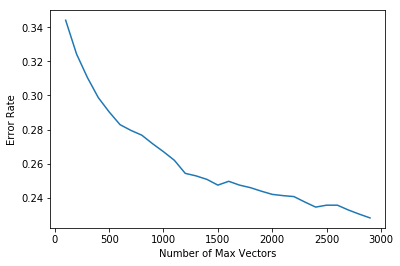

<Figure size 432x288 with 0 Axes>

In [7]:
#Printing out the optimal max features value and plot the results
optimal_n = features_n[scores.index(min(scores))]
print ("The optimal number of max vectors is %d" % optimal_n + " with an error rate of %.3f" % min(scores))
plt.plot(features_n, scores)
plt.xlabel('Number of Max Vectors')
plt.ylabel('Error Rate')
plt.show()
plt.savefig('Sarcasm_Error')

In [8]:
print('Confusion matrix\n',confusion_matrix(y_test, y_pred))

Confusion matrix
 [[2555  452]
 [ 766 1569]]


In [9]:
print('Classification_report\n',classification_report(y_test, y_pred))

Classification_report
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      3007
           1       0.78      0.67      0.72      2335

   micro avg       0.77      0.77      0.77      5342
   macro avg       0.77      0.76      0.76      5342
weighted avg       0.77      0.77      0.77      5342



In [10]:
scores

[0.34425308873081245,
 0.32441033320853613,
 0.3105578435043055,
 0.2987645076750281,
 0.2903406963684014,
 0.28285286409584426,
 0.27948333957319355,
 0.27667540247098465,
 0.2716211156870086,
 0.2669412205166604,
 0.2618869337326844,
 0.25421190565331336,
 0.25271433919880193,
 0.25065518532384873,
 0.24728566080119804,
 0.2495320104829652,
 0.24728566080119804,
 0.24578809434668664,
 0.24372894047173344,
 0.24185698240359416,
 0.24110819917633844,
 0.24054661175589667,
 0.2373642830400599,
 0.23436915013103707,
 0.23549232497192063,
 0.23549232497192063,
 0.2326843878697117,
 0.23025084238113067,
 0.22800449269936354]

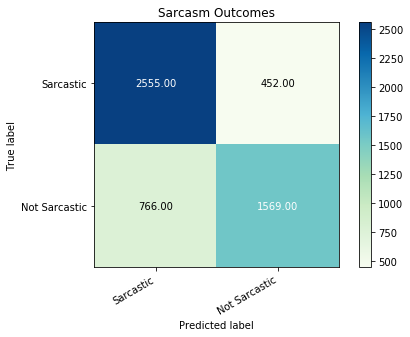

In [11]:
classes = ['Sarcastic','Not Sarcastic']
plt.rcParams["figure.figsize"] = (7,5)
normalize = True
cm =confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.GnBu)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title= "Sarcasm Outcomes",
       ylabel='True label',
       xlabel='Predicted label')
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.autofmt_xdate()
plt.savefig('Sarcasm_Confusion_Matrix')

In [12]:
def important_features_per_class(vectorizer,classifier,n=80):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
    print("Important words in non-sarcastic documents")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print("-----------------------------------------")
    print("Important words in sarcastic documents")
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat) 

In [13]:
important_features_per_class(tf, classifier2)

Important words in non-sarcastic documents
0 278.2086392239899 trump
0 132.1798462492476 new
0 115.88181884613934 woman
0 113.38775576324605 donald
0 110.6599130637361 donald trump
0 94.52798428996708 year
0 92.91152321310378 say
0 77.5346821753179 way
0 75.76813426370592 good
0 74.95687359418112 thing
0 74.81671046275575 life
0 72.12041932689121 day
0 71.4111673563867 want
0 71.07489158651512 world
0 69.71736076799927 people
0 69.68987899732612 need
0 69.24637930038001 man
0 67.95435793172456 get
0 67.7446670093969 american
0 65.13802744764696 time
0 64.40317778846645 watch
0 63.89213360446436 love
0 62.91645497560617 obama
0 61.5649652204268 america
0 61.18047458202306 gop
0 60.98833506185811 know
0 58.54737645805147 change
0 58.52916076680944 black
0 58.25189504855988 kid
0 57.96914331703061 like
0 55.61524387019098 white
0 55.49666276542019 look
0 54.9097813797006 clinton
0 54.78107520526597 president
0 54.64576347422986 help
0 53.106485027301815 state
0 52.194501664307836 talk
0 5

In [14]:
feature_to_coef = {
    word: coef for word, coef in zip(
        tf.get_feature_names(), classifier.coef_[0]
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
print("-----------------------------------------")

for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)


('area', 5.832572834562479)
('nation', 5.48487841509498)
('report', 4.690201557952062)
('man', 4.4830911532991395)
('local', 3.89692077740186)
-----------------------------------------
('trump', -4.581120774987403)
('donald', -2.9147535189204783)
('queer', -2.7920795690209173)
('donald trump', -2.5054991639175217)
('tweet', -2.3928588271197686)
